In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from mne.decoding import cross_val_multiscore
from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import Union
from utils.beep import Beeper
from sklearn.base import BaseEstimator
from abc import ABC, abstractmethod
from typing import Optional, Iterable, Generator, Callable
from mne import EpochsArray
from collections import UserDict, UserList
from combiners import EpochsCombiner
from mne.decoding import SlidingEstimator

# speakers
sad_beep = Beeper(duration=[.1, .15, .25], frequency=[280, 240, 190], repeat=3)
happy_beep = Beeper(duration=[.1, .1, .15, .25], frequency=[400, 370, 470, 500], repeat=4)

# paths
content_root = '../'
subjects_folder_path = os.path.join(content_root, 'Source/Subjects')
subject_path = os.path.join(subjects_folder_path, 'Az_Mar_05')
raw_file_path = os.path.join(subject_path, 'Raw', 'ML_Subject05_P1_tsss_mc_trans.fif')
raw_path = os.path.join(subject_path, 'Raw', 'ML_Subject05_P1_tsss_mc_trans.fif')
resp_lock_lm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'resp_lock_lm_B1_epochs.fif')
resp_lock_rm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'resp_lock_rm_B1_epochs.fif')
resp_lock_li_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'resp_lock_li_B1_epochs.fif')
resp_lock_ri_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'resp_lock_ri_B1_epochs.fif')

# readers
original_data = mne.io.read_raw_fif(raw_file_path)
original_info = original_data.info
resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)

# classifier

# clf = make_pipeline(
#     CSP(
#         n_components=2,
#         reg='shrinkage',
#         rank='full'
#     ),
#     LogisticRegression(penalty='l1', solver='saga')
# )

clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))

# variables

n_splits = 5
tmin, tmax = -.500, .500
n_cycles = 10.
min_freq = 5.
max_freq = 25.
n_freqs = 8
freqs = np.linspace(min_freq, max_freq, n_freqs)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))
window_spacing = (n_cycles / np.max(freqs) / 2.)
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# cross-validator

cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# combiner

combiner = EpochsCombiner(resp_lock_lm_B1_epochs, resp_lock_li_B1_epochs, resp_lock_rm_B1_epochs, resp_lock_ri_B1_epochs)

# time-decoder

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)

Opening raw data file ../Source/Subjects/Az_Mar_05/Raw/ML_Subject05_P1_tsss_mc_trans.fif...
    Range : 25000 ... 1114999 =     25.000 ...  1114.999 secs
Ready.
Reading ../Source/Subjects/Az_Mar_05/Epochs/resp_lock_lm_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/resp_lock_rm_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/resp_lock_li_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_43613/1537181865.py:44: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Raw/ML_Subject05_P1_tsss_mc_trans.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  original_data = mne.io.read_raw_fif(raw_file_path)
/tmp/ipykernel_43613/1537181865.py:46: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/resp_lock_lm_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
/tmp/ipykernel_43613/1537181865.py:47: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/resp_lock_rm_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.f

Not setting metadata
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/resp_lock_ri_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_43613/1537181865.py:49: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/resp_lock_ri_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)


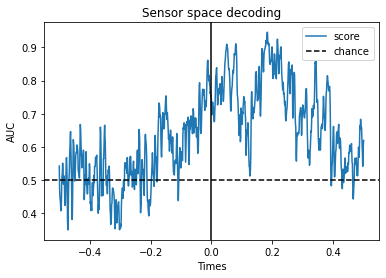

In [3]:
first_class_indices = (0, 1)
second_class_indices = (2, 3)

combiner.combine(first_class_indices, second_class_indices, shuffle=True)

# scorer

scores = np.mean(
        cross_val_multiscore(time_decod, combiner.X, combiner.Y, cv=5, n_jobs=1),
        axis=0
    )

times = np.linspace(-.5, .5, scores.shape[0])
fig, ax = plt.subplots()
ax.plot(times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

happy_beep()

In [8]:
print(original_info)
print(resp_lock_rm_B1_epochs.info == original_info)

<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 GRAD, 102 MAG, 11 STIM, 2 EOG, 1 ECG, 9 EMG, 1 MISC, 9 CHPI
 custom_ref_applied: False
 description: Vectorview system
 dev_head_t: MEG device -> head transform
 dig: 138 items (3 Cardinal, 4 HPI, 131 Extra)
 events: 1 item (list)
 experimenter: meg
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date: 2018-11-23 11:23:40 UTC
 meas_id: 4 items (dict)
 nchan: 339
 proc_history: 2 items (list)
 proj_id: 1 item (ndarray)
 proj_name: russell
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 6 items (dict)
>
False



No projector specified for this dataset. Please consider the method self.add_proj.


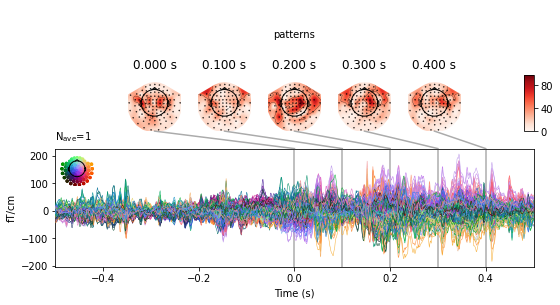

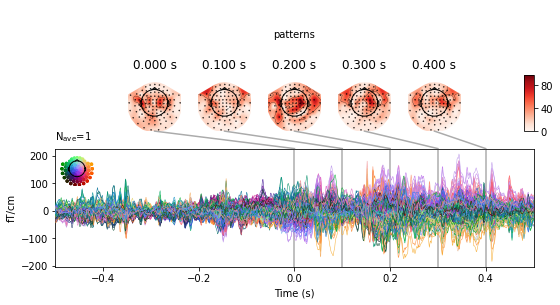

In [9]:
# plot patterns
# Err: some channels are dropped!

from mne.decoding import get_coef, LinearModel

clf = make_pipeline(StandardScaler(),
                    LinearModel(LogisticRegression(solver='lbfgs')))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)

time_decod.fit(combiner.X, combiner.Y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, resp_lock_rm_B1_epochs.info, tmin=times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked_time_gen.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                           **joint_kwargs)



In [ ]:
# temporal generalization
# Warn: very slow code!

from mne.decoding import GeneralizingEstimator

time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc',
                                 verbose=True)

scores = cross_val_multiscore(time_gen, combiner.X, combiner.Y, cv=5, n_jobs=1)

scores = np.mean(scores, axis=0)

fig, ax = plt.subplots()
ax.plot(times, np.diag(scores), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')